In [27]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
import os
import numpy as np

In [29]:
ner_df = pd.read_csv('/content/drive/My Drive/datasets/ner_dataset.csv', engine='python', na_values='NaN')

In [30]:
BATCHSIZE = 64
EPOCH = 10
LATENT_DIM = 100
LATENT_DIM_DECODER = LATENT_DIM
SAMPLES = 10000
MAX_WORD_NUM = SAMPLES
MAX_SEQ_LEN = 100
EMBEDDING = MAX_SEQ_LEN

In [31]:
ner_df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [32]:
sentences_words = []
sentences_tags = []
current_sentence_words = []
current_sentence_tags = []
for sent_num, word, tag in ner_df[['Sentence #', 'Word', 'Tag']].values: 
    if pd.notna(sent_num) and current_sentence_words and current_sentence_tags:
            sentences_words.append(current_sentence_words)
            sentences_tags.append(current_sentence_tags)
            current_sentence_words = []
            current_sentence_tags = []
    current_sentence_words.append(word)
    current_sentence_tags.append(tag)

In [33]:
vocab = set(itertools.chain.from_iterable(s for s in sentences_words)) 
tags = set(itertools.chain.from_iterable(s for s in sentences_tags))
sentenecs_lens = list(map(len, sentences_words))

In [34]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [35]:
words_tokenizer = Tokenizer(num_words=MAX_WORD_NUM)
words_tokenizer.fit_on_texts(sentences_words)
word_index = words_tokenizer.word_index
max_in_len = max(len(s) for s in sentences_words)
print(f"Number of input tokens: {len(word_index)}")
print(f"Maximum input sequence length: {max_in_len}")

Number of input tokens: 31811
Maximum input sequence length: 104


In [36]:
words_seq = words_tokenizer.texts_to_sequences(sentences_words)

In [37]:
words_seq_pad = pad_sequences(words_seq, maxlen=max_in_len)

In [38]:
tags_tokenizer = Tokenizer(num_words=MAX_WORD_NUM, filters='')
tags_tokenizer.fit_on_texts(sentences_tags)
tag_index = tags_tokenizer.word_index
max_out_len = max(len(s) for s in sentences_tags)
out_word_num = len(tag_index) + 1
print(f"Number of output tokens: {len(tag_index)}")
print("Maximum output sequence length: {}".format(max_out_len))

Number of output tokens: 17
Maximum output sequence length: 104


In [39]:
tags_seq = tags_tokenizer.texts_to_sequences(sentences_tags)

In [40]:
tags_seq_pad = pad_sequences(tags_seq, maxlen=max_out_len)

In [41]:
wordVec = {}
print('Loading wordVec')
with open('/content/drive/My Drive/datasets/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        data = line.split()
        word = data[0]
        vec = np.asarray(data[1:], dtype='float32')
        wordVec[word] = vec
print('Finished loading wordVec.')

Loading wordVec
Finished loading wordVec.


In [42]:
wordNum = min(MAX_WORD_NUM, len(word_index) + 1)
word_embedding = np.zeros((wordNum, EMBEDDING))

for tok, idx in word_index.items():
    if idx < MAX_WORD_NUM:
        word_vector = wordVec.get(tok)
        if word_vector is not None:
            word_embedding[idx] = word_vector

In [43]:
man_target_one_hot = np.zeros((len(sentences_words), max_out_len, out_word_num), dtype='float32')

for idx, tokVec in enumerate(tags_seq_pad):
    for tok_idx, tok in enumerate(tokVec):
        if (tok > 0):
            man_target_one_hot[idx, tok_idx, tok] = 1

In [44]:
from keras.layers import Embedding, Input, LSTM, GRU, Dense, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
import keras.backend as K
from keras.models import Model

In [45]:
# Embedding
embedding = Embedding(wordNum, EMBEDDING, weights=[word_embedding], input_length=max_in_len)

# Encoder
input_layer_encoder = Input(shape=(max_in_len,))
embed_encoder = embedding(input_layer_encoder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.2))
encoder_out = encoder(embed_encoder)

# Decoder input
input_layer_decoder = Input(shape=(max_out_len,))
embed_decoder = Embedding(out_word_num, EMBEDDING)
decoder_input = embed_decoder(input_layer_decoder)

# Decoder output, after attention
decoder = LSTM(LATENT_DIM_DECODER, return_state=True)
dense_decode = Dense(out_word_num, activation='softmax')
s0 = Input(shape=(LATENT_DIM_DECODER,))
c0 = Input(shape=(LATENT_DIM_DECODER,))

In [46]:
# Dimension of x is N x T x D.
def softmax(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

repeat_attn = RepeatVector(max_in_len)
concat_attn = Concatenate(axis=-1)
dense1_attn = Dense(10, activation='tanh')
# dense1_attn = Dense(5, activation='tanh') 
dense2_attn = Dense(1, activation=softmax)
dot_attn = Dot(axes=1)                      

def iterAttn(h, prevOut):
    prevOutRepeat = repeat_attn(prevOut)
    total = concat_attn([h, prevOutRepeat])
    d = dense1_attn(total)
    alphaLayer = dense2_attn(d)
    context = dot_attn([alphaLayer, h])
    
    return context

In [47]:
s = s0
c = c0

all_out = []
for t in range(max_out_len):
    context = iterAttn(encoder_out, s) 
    
    select_layer = Lambda(lambda x: x[:, t:t+1])
    prevWord = select_layer(decoder_input)
    
    concat2 = Concatenate(axis=2)
    decoder_in_concat = concat2([context, prevWord])
    
    pred, s, c = decoder(decoder_in_concat, initial_state=[s, c])
    pred = dense_decode(pred)
    all_out.append(pred)

In [48]:
def stack(outputs):
    outputs = K.stack(outputs)
    return K.permute_dimensions(outputs, pattern=(1, 0, 2))

stack_layer = Lambda(stack)
all_out = stack_layer(all_out)

In [49]:
attnModel = Model(inputs=[input_layer_encoder, input_layer_decoder, s0, c0,],
                 outputs=all_out)

In [50]:
def myLoss(y_train, pred):
    mask = K.cast(y_train > 0, dtype='float32')
    val = mask * y_train * K.log(pred)
    return -K.sum(val) / K.sum(mask)

def acc(y_train, pred):
    targ = K.argmax(y_train, axis=-1)
    pred = K.argmax(pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    mask = K.cast(K.greater(targ, 0), dtype='float32')
    correctCount = K.sum(mask * correct)
    totalCount = K.sum(mask)
    return correctCount / totalCount

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [51]:
attnModel.compile(optimizer='adam', loss=myLoss, metrics=[acc, recall_m, precision_m, f1_m])

init_s = np.zeros((len(words_seq_pad), LATENT_DIM_DECODER))
init_c = np.zeros((len(words_seq_pad), LATENT_DIM_DECODER))

history = attnModel.fit(
    x=[words_seq_pad, tags_seq_pad, init_s, init_c],
    y=man_target_one_hot,
    batch_size=BATCHSIZE,
    epochs=EPOCH,
    validation_split=0.3
)

Epoch 1/10
525/525 [==============================] - 1786s 3s/step - loss: 0.8396 - acc: 0.8358 - recall_m: 0.7998 - precision_m: 0.1715 - f1_m: 0.2821 - val_loss: 0.6619 - val_acc: 0.8464 - val_recall_m: 0.8464 - val_precision_m: 0.1797 - val_f1_m: 0.2963
Epoch 2/10
525/525 [==============================] - 1604s 3s/step - loss: 0.6533 - acc: 0.8465 - recall_m: 0.8463 - precision_m: 0.1800 - f1_m: 0.2968 - val_loss: 0.6333 - val_acc: 0.8464 - val_recall_m: 0.8460 - val_precision_m: 0.1802 - val_f1_m: 0.2970
Epoch 3/10
525/525 [==============================] - 1593s 3s/step - loss: 0.6290 - acc: 0.8470 - recall_m: 0.8464 - precision_m: 0.1806 - f1_m: 0.2975 - val_loss: 0.6263 - val_acc: 0.8464 - val_recall_m: 0.8463 - val_precision_m: 0.1801 - val_f1_m: 0.2968
Epoch 4/10
525/525 [==============================] - 1622s 3s/step - loss: 0.6216 - acc: 0.8465 - recall_m: 0.8459 - precision_m: 0.1812 - f1_m: 0.2984 - val_loss: 0.6232 - val_acc: 0.8464 - val_recall_m: 0.8459 - val_precisi

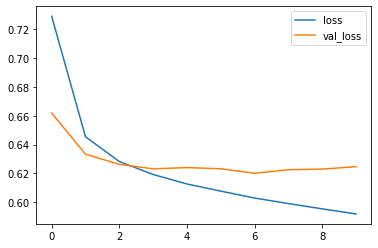

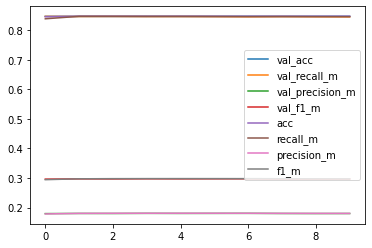

In [52]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(history.history['val_recall_m'], label='val_recall_m')
plt.plot(history.history['val_precision_m'], label='val_precision_m')
plt.plot(history.history['val_f1_m'], label='val_f1_m')
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['recall_m'], label='recall_m')
plt.plot(history.history['precision_m'], label='precision_m')
plt.plot(history.history['f1_m'], label='f1_m')
plt.legend()
plt.show()